In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler


import nibabel

In [2]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [3]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [4]:
len(available_segments)

46

In [5]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True):
        
#         rand = np.arange(171008)
#         np.random.shuffle(rand)
#         rand = rand[:150]
#         print(rand)
#         self.image_dir = list(unpickling(image_dir))[rand]
#         self.label_dir = list(unpickling(label_dir))[rand]
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = self.image_dir[idx]
        aseg_path = self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))/255
        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((46,256,256))
        for i,a in enumerate(available_segments):
            target_label[i,:,:] = (target==a).astype(int)
        target_label = torch.from_numpy(target_label)
        sample = {'x':im,'y':target_label} 
        return sample

In [6]:
# torch.from_numpy()
train_file_names = unpickling("/scratch/ark576/train_file_names")
train_label_names = unpickling("/scratch/ark576/train_label_names")
rand1 = np.arange(len(train_file_names))
np.random.shuffle(rand1)
rand1 = rand1[:1000]

val_file_names = unpickling("/scratch/ark576/val_file_names")
val_label_names = unpickling("/scratch/ark576/val_label_names")
rand2 = np.arange(len(val_file_names))
np.random.shuffle(rand2)
rand2 = rand2[:250]

test_file_names = unpickling("/scratch/ark576/test_file_names")
test_label_names = unpickling("/scratch/ark576/test_label_names")
rand3 = np.arange(len(test_file_names))
np.random.shuffle(rand3)
rand3 = rand3[:3]



In [7]:
# transformed_dataset = {'train': BrainImages("train_file_names","train_label_names", train_data= True, flipping=False),
#                        'validate': BrainImages("val_file_names","val_label_names"),
#                        'test': BrainImages("test_file_names","test_label_names")}
transformed_dataset = {'train': BrainImages(np.array(train_file_names)[rand1],np.array(train_label_names)[rand1], train_data= True, flipping=False),
                       'validate': BrainImages(np.array(val_file_names)[rand2],np.array(val_label_names)[rand2]),
                       'test': BrainImages(np.array(test_file_names)[rand3],np.array(test_label_names)[rand3])
                                               }



dataloader = {x: DataLoader(transformed_dataset[x], batch_size=15,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [8]:
#eg_path = '/scratch/ark576/data-reduced/996782/seperated_images/aseg_images/'

In [9]:
#eg_labels = os.listdir(eg_path)

In [10]:
#for i in range(len(eg_labels)):
#    eg_labels[i] = eg_path+eg_labels[i]

In [11]:
# eg_image_path = '/scratch/ark576/data-reduced/996782/seperated_images/t1_images/'
# eg_images = os.listdir(eg_image_path)
# for i in range(len(eg_images)):
#     eg_images[i] = eg_image_path+eg_images[i]

In [12]:
# transformed_dataset = {'train': BrainImages(np.array(eg_images),np.array(eg_labels), train_data= True, flipping=False),
#                        'validate': BrainImages(np.array(val_file_names)[rand2],np.array(val_label_names)[rand2]),
#                        'test': BrainImages(np.array(test_file_names)[rand3],np.array(test_label_names)[rand3])
#                                                }



# dataloader = {x: DataLoader(transformed_dataset[x], batch_size=15,
#                         shuffle=True, num_workers=0) for x in ['train']}
# data_sizes ={x: len(transformed_dataset[x]) for x in ['train']}

In [13]:
#label_dir = unpickling("/scratch/ark576/train_file_names")

In [14]:
#len(label_dir)

In [18]:
inputs = next(iter(dataloader['train']))

In [19]:
# def imshow(inp):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose(1,2,0)
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)

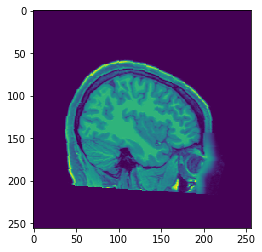

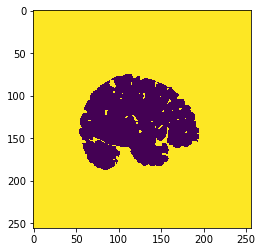

In [20]:
j = 3
plt.imshow(inputs['x'][1,0,:,:].numpy())
plt.show()
plt.imshow(inputs['y'][1,0,:,:].numpy())
plt.show()

In [21]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [22]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [23]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(1,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,46, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [24]:
# def dice_loss(true,scores, epsilon = 1e-4):
#     preds = F.softmax(scores)
#     N, C, sh1, sh2 = true.size()
#     true = true.view(N, C, -1)
#     preds = preds.view(N, C, -1)
#     wts = torch.sum(true, dim = 2) + epsilon
# #     print(wts)
#     wts = 1/torch.pow(wts,2)
#     wts = torch.clamp(wts,0,0.1)
#     wts[wts == 0.1] = 0
#     wts = wts/Variable(torch.sum(wts,dim = 1).data.unsqueeze_(1))
#     print(wts)
#     prod = torch.sum(true*preds,dim = 2)
#     sum_tnp = torch.sum(true + preds, dim = 2)
#     num = torch.sum(wts * prod, dim = 1)
#     denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
#     loss = 1 - 2*(num/denom)
#     return torch.mean(loss)

In [25]:
voxel_count = pd.read_csv('/scratch/ark576/segment_counts.csv')

In [26]:
wts_num = np.mean(np.array(voxel_count.iloc[:,available_segments]),axis = 0)

In [27]:
wts_num

array([  1.55181717e+07,   2.27132558e+05,   2.71765411e+05,
         6.20701527e+03,   1.97743037e+02,   1.40333845e+04,
         5.66883971e+04,   8.58384546e+03,   3.93285085e+03,
         5.57085894e+03,   1.45641330e+03,   7.34502246e+02,
         1.62191195e+03,   2.17487646e+04,   4.58532974e+03,
         1.62259928e+03,   1.07495148e+03,   5.93299191e+02,
         4.35026595e+03,   5.97843666e+01,   1.32094160e+03,
         2.34319566e+05,   2.76456036e+05,   5.75684007e+03,
         2.13104223e+02,   1.42446190e+04,   5.83411680e+04,
         7.62657951e+03,   3.99412040e+03,   5.70409075e+03,
         1.51298922e+03,   4.62344924e+03,   1.70840701e+03,
         6.55268643e+02,   4.41450494e+03,   6.94510332e+01,
         1.43331087e+03,   4.20664870e+00,   9.93678347e+02,
         9.23360288e+00,   2.37004492e+02,   9.80229111e+02,
         5.00247978e+02,   5.20355795e+02,   5.22881402e+02,
         9.22082659e+02])

In [28]:
wts_torch = Variable(torch.from_numpy(wts_num)).cuda()

In [29]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 1):
    preds = F.softmax(scores)
    N, C, sh1, sh2 = true.size()
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
#     print(wts)
    mean = 1/torch.pow(mean,p)
#     print(wts.size())
#     print(mean)
#     wts = torch.clamp(wts,0,0.1)
    wts[:,:] = mean[None].repeat(N,1)
#     wts[:,-1] = 0
#     wts[wts == 0.1] = 0
    wts = wts/(torch.sum(wts,dim = 1)[:,None])
    #print(wts)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    return torch.mean(loss)

In [30]:
def dice_score(true,scores, epsilon = 1e-7):
    N ,C, sh1, sh2 = true.size()
    true = true.view(N,C,-1)
    #print(true.size())
    preds = F.softmax(scores)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*46
    for i in range(46):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
        
#     class_0_pred_seg = (pred_class == 0).data.type(torch.cuda.FloatTensor)
#     class_1_pred_seg = (pred_class == 1).data.type(torch.cuda.FloatTensor)
#     class_2_pred_seg = (pred_class == 2).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        #print(type(truth))
        #print(truth[:,int(idx),:].size())
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*46
    for i in range(46):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
#     dice_score_class_0 = torch.mean(2*(numerator(true,class_0_pred_seg,0))/(denominator(true,class_0_pred_seg,0)))
#     dice_score_class_1 = torch.mean(2*(numerator(true,class_1_pred_seg,1))/(denominator(true,class_1_pred_seg,1)))
#     dice_score_class_2 = torch.mean(2*(numerator(true,class_2_pred_seg,2))/(denominator(true,class_2_pred_seg,2)))
    
#    return (dice_score_class_0,dice_score_class_1, dice_score_class_2)
    return dice_class_score
    

In [31]:
# truth = Variable(torch.rand(2,3,2,2)).type(torch.FloatTensor)

In [32]:
# pred = Variable(torch.rand(2,3,2,2)).type(torch.FloatTensor)

In [33]:
#dice_score(truth,pred)

In [34]:
#dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(46)]

In [66]:
#dice_scores_of_all_class[0].append([])

In [73]:
#dice_scores_of_all_class[0]['train'].append(0)

In [49]:
#dice_scores_of_all_class[0]['train'][1]=2

In [77]:
#dice_scores_of_all_class[0]['train'].append(2)

In [39]:
#dice_scores_of_all_class

In [35]:
import time
def train_model(model, optimizer,dataloader, data_sizes, batch_size, num_epochs = 100, verbose = False):
    since = time.time()
    best_loss = np.inf
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(46)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*46
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).type(torch.FloatTensor).cuda()
                y = Variable(y).type(torch.FloatTensor).cuda()
                
                output = model(x)
                loss = dice_loss_2(y, output,wts_torch)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * batch_size
                dice_score_batch = dice_score(y,output)

                for j in range(46):
                    run_class_scores[j] = run_class_scores[j] + dice_score_batch[j] * batch_size
            epoch_loss = running_loss/data_sizes[phase]
            loss_hist[phase].append(epoch_loss) 
            for j in range(46):
                score = run_class_scores[j]/data_sizes[phase]
                dice_scores_of_all_class[j][phase].append(score)
            if verbose or i%1 == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}'.format(i,phase,epoch_loss))
                print('-'*10)
            
        if phase == 'validate' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = model.state_dict() 
        print(i)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}'.format(best_loss))
    
    model.load_state_dict(best_model_wts)
    
    return model, loss_hist, dice_scores_of_all_class

In [36]:
#saved_model = Unet().cuda()

In [37]:
model = Unet().cuda()
model = nn.DataParallel(model)
criterion = dice_loss_2

optimizer = optim.Adam(model.parameters(),lr = 5e-4)

In [38]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,data_sizes,15,
                                                                num_epochs = 12, verbose = True)

Epoch: 0, Phase: train, epoch loss: 1.0050
----------
Epoch: 0, Phase: validate, epoch loss: 1.0199
----------
0
Epoch: 1, Phase: train, epoch loss: 1.0047
----------
Epoch: 1, Phase: validate, epoch loss: 1.0191
----------
1
Epoch: 2, Phase: train, epoch loss: 1.0031
----------
Epoch: 2, Phase: validate, epoch loss: 1.0129
----------
2
Epoch: 3, Phase: train, epoch loss: 0.9871
----------
Epoch: 3, Phase: validate, epoch loss: 0.9915
----------
3
Epoch: 4, Phase: train, epoch loss: 0.9249
----------
Epoch: 4, Phase: validate, epoch loss: 0.9803
----------
4
Epoch: 5, Phase: train, epoch loss: 0.8054
----------
Epoch: 5, Phase: validate, epoch loss: 0.7954
----------
5
Epoch: 6, Phase: train, epoch loss: 0.4654
----------
Epoch: 6, Phase: validate, epoch loss: 0.3587
----------
6
Epoch: 7, Phase: train, epoch loss: 0.4025
----------
Epoch: 7, Phase: validate, epoch loss: 0.3346
----------
7
Epoch: 8, Phase: train, epoch loss: 0.3876
----------
Epoch: 8, Phase: validate, epoch loss: 0.3

In [44]:
names = []
for i in range(12):
    name = "epoch"+str(i)
    names.append(name)

In [45]:
train_dice_scores = pd.DataFrame(columns=names)
val_dice_scores = pd.DataFrame(columns=names)

In [47]:
for i in range(46):
    class_i_train = dice_hist[i]['train']
    class_i_val = dice_hist[i]['validate']
    
    train_dice_scores.loc[i] = class_i_train
    val_dice_scores.loc[i] = class_i_val

## Train Dice score for 12 epocs

In [48]:
train_dice_scores

,epoch0,epoch1,epoch2,epoch3,epoch4,epoch5,epoch6,epoch7,epoch8,epoch9,epoch10,epoch11
0,0.000247,0.010184,6.939134e-07,0.058266,0.711290,0.870291,0.977607,0.989341,0.993015,0.991881,0.993889,0.994425
1,0.740000,0.743000,7.425000e-01,0.743000,0.742000,0.743000,0.743000,0.741500,0.741500,0.742500,0.743000,0.743500
2,0.268480,0.271690,1.994509e-01,0.078253,0.353959,0.354326,0.573093,0.645494,0.662625,0.652027,0.673786,0.678169
3,0.328118,0.395586,5.448353e-02,0.158544,0.614296,0.783625,0.888000,0.887500,0.886000,0.887000,0.887500,0.888000
4,0.000074,0.051751,6.395748e-01,0.951500,0.951000,0.952000,0.952000,0.952000,0.951500,0.951500,0.952000,0.952000
5,0.785000,0.831500,5.641340e-01,0.821000,0.835500,0.836500,0.837000,0.835000,0.834500,0.835500,0.836000,0.837000
6,0.444041,0.779000,6.145000e-01,0.779000,0.778500,0.779000,0.779000,0.777500,0.777500,0.778500,0.779000,0.780000
7,0.233952,0.309523,5.471058e-01,0.911500,0.911000,0.912000,0.912000,0.911500,0.910500,0.911000,0.911500,0.912000
8,0.587036,0.911000,9.360000e-01,0.936500,0.936500,0.937000,0.937000,0.936500,0.935500,0.936500,0.936500,0.937000
9,0.463500,0.575500,7.430000e-01,0.915500,0.915000,0.916000,0.916000,0.916000,0.914000,0.915000,0.915500,0.916000


## Validation dice score for 11 epocs

In [49]:
val_dice_scores

,epoch0,epoch1,epoch2,epoch3,epoch4,epoch5,epoch6,epoch7,epoch8,epoch9,epoch10,epoch11
0,8.419816e-06,1.683996e-12,1.683360e-12,0.424249,0.967176,0.802471,1.003908,1.009904,1.007708,1.007192,1.009654,1.011759
1,7.480000e-01,7.540000e-01,7.560000e-01,0.748000,0.748000,0.748000,0.752000,0.758000,0.758000,0.756000,0.758000,0.758000
2,3.720000e-01,4.050932e-01,4.256136e-01,0.492386,0.030292,0.270972,0.720911,0.763592,0.757640,0.759863,0.773540,0.787122
3,8.740000e-01,3.368171e-09,1.565517e-01,0.404899,0.849841,0.888000,0.892000,0.896000,0.894000,0.892000,0.894000,0.894000
4,3.979016e-10,2.680000e-01,9.460000e-01,0.946000,0.938000,0.946000,0.948000,0.948000,0.946000,0.948000,0.946000,0.946000
5,8.420000e-01,8.500000e-01,1.640000e-01,0.844000,0.842000,0.842000,0.848000,0.852000,0.850000,0.848000,0.850000,0.850000
6,7.720000e-01,7.180000e-01,7.800000e-01,0.772000,0.772000,0.774000,0.776000,0.782000,0.782000,0.780000,0.782000,0.782000
7,3.660000e-01,3.660000e-01,9.240000e-01,0.922000,0.922000,0.922000,0.926000,0.928000,0.926000,0.924000,0.928000,0.926000
8,9.520000e-01,9.700000e-01,9.700000e-01,0.968000,0.968000,0.968000,0.972000,0.972000,0.972000,0.970000,0.972000,0.970000
9,8.860000e-01,9.100000e-01,9.080000e-01,0.904000,0.904000,0.908000,0.910000,0.912000,0.910000,0.912000,0.910000,0.910000


## Overall Dice loss

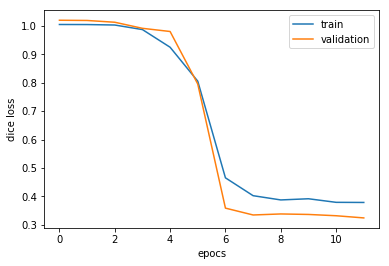

In [41]:
plt.plot(loss_hist["train"],label="train")
plt.plot(loss_hist["validate"],label = "validation")
plt.ylabel("dice loss")
plt.xlabel("epocs")
plt.legend()
plt.show()

In [27]:
log_df = pd.read_csv("log_df.csv")
log_model_detail = pd.read_csv("log_model_detail.csv")
# log_df["job-model3-train-10000-54lr-15epoc"] = loss_hist["train"]
# log_df["job-model3-val-10000-54lr-15epoc"] = loss_hist["validate"]
# log_df.to_csv("log_df.csv",index=False)


In [56]:
# log_df = pd.DataFrame()
# log_df["train-model2-60ep-54lr"] = loss_hist["train"]

In [115]:
# log_df["val-model2-60epoc-54lr"] = loss_hist["validate"]


In [122]:
#log_model_detail = pd.DataFrame(columns=["model_name","n_epocs","lr","train_size","val_size","time_to_train"])

In [123]:
#log_model_detail.loc[0] = ["model2-60epoc-54lr",60,5e-4,1000,250,"187m 21s"]

In [125]:
#log_model_detail.loc[1] = ["job-model3-train-10000-54lr-15epoc",15,5e-4,10000,500,"unknown_yet"] 

In [127]:
#log_model_detail.to_csv("log_model_detail.csv",index=False)

In [38]:
log_model_detail

,model_name,n_epocs,lr,train_size,val_size,time_to_train
0,model2-60epoc-54lr,60,0.0005,1000,250,187m 21s
1,job-model3-train-10000-54lr-15epoc,60,0.0005,10000,500,1140 m


In [28]:
log_df

,train-model2-60ep-54lr,val-model2-60epoc-54lr,job-model3-train-10000-54lr-15epoc,job-model3-val-10000-54lr-15epoc
0,1.007970,1.007959,0.706104,0.382323
1,1.007850,1.007464,0.365590,0.379418
2,1.006987,1.006976,0.361220,0.363653
3,0.998581,0.986278,0.360624,0.360698
4,0.977035,0.958624,0.360189,0.361771
5,0.924728,0.932834,0.358533,0.361550
6,0.785197,0.800749,0.358795,0.360421
7,0.474804,0.378078,0.359170,0.360012
8,0.387180,0.363345,0.358171,0.359662
9,0.384012,0.385188,0.357640,0.360637


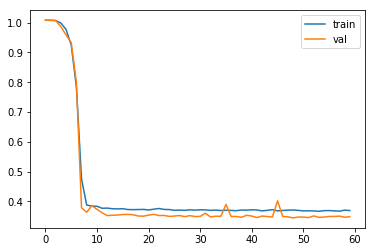

In [55]:
plt.plot(log_df["train-model2-60ep-54lr"],label="train")
plt.plot(log_df["val-model2-60epoc-54lr"],label="val")
plt.legend()
plt.show()

In [56]:
min(log_df["val-model2-60epoc-54lr"])

0.3441625964641571

In [82]:
#log_df.to_csv("log_df.csv",index=False)

In [60]:
# optimizer = optim.Adam(model.parameters(),lr = 1e-5)
# model, loss_hist = train_model(model, optimizer,dataloader,data_sizes,5,
#                                                                 num_epochs = 25, verbose = True)

In [43]:
# pickling(model,"model1-50ep-15lr")
torch.save(model,'model2-60epoc-54lr')

In [48]:
#torch.load("model2-60epoc-54lr")

In [112]:
saved_model = Unet().cuda()
saved_model = nn.DataParallel(saved_model)

In [113]:
saved_model = torch.load("job-model3-train-10000-54lr-15epoc")

TypeError: <module '__main__'> is a built-in class

In [80]:
data = next(iter(dataloader["validate"]))

In [81]:
saved_model.train(False)
x = data['x']
y = data['y']
x = Variable(x).type(torch.FloatTensor).cuda()
y = Variable(y).type(torch.FloatTensor).cuda()
                
output = saved_model(x)



In [60]:
print(data['y'].size())
print(output.size())

torch.Size([18, 46, 256, 256])
torch.Size([18, 46, 256, 256])


In [61]:
def visualize(image, class_viz, title):
    p = F.softmax(image)
    p_maxim = torch.max(p, dim=0)[1]
    masked = (p_maxim==class_viz).data.type(torch.cuda.FloatTensor)
    plt.title(title)
    plt.imshow(masked[:,:].cpu().numpy())

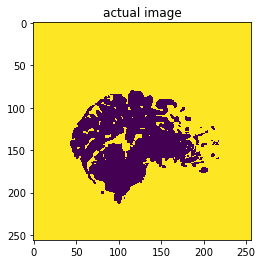

In [67]:
visualize(data['y'][1,:,:,:],0,"actual image")

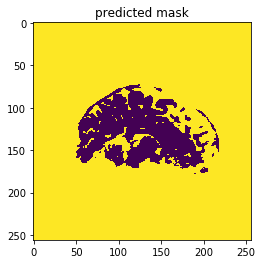

In [68]:
visualize(output[1,:,:,:],0,"predicted mask")

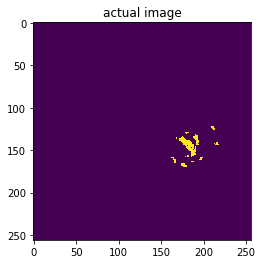

In [72]:
visualize(data['y'][1,:,:,:],2,"actual image")

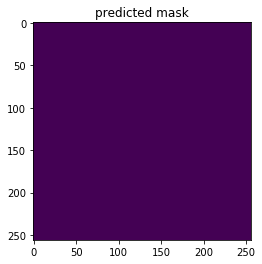

In [114]:
visualize(output[1,:,:,:],2,"predicted mask")

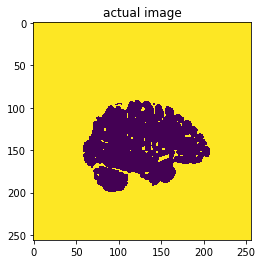

In [86]:
visualize(data['y'][3,:,:,:],0,"actual image")

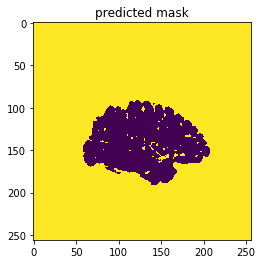

In [94]:
visualize(output[3,:,:,:],0,"predicted mask")

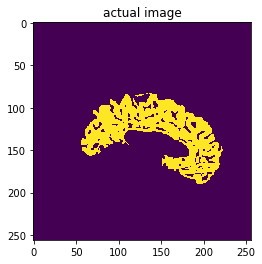

In [98]:
visualize(data['y'][4,:,:,:],2,"actual image")

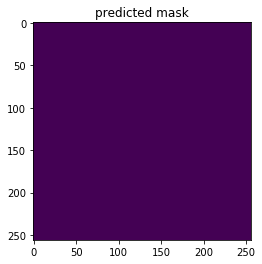

In [99]:
visualize(output[4,:,:,:],2,"predicted mask")

In [80]:
#visualize(data['y'][10,:,:,:],17)

In [81]:
#plt.imshow(output[10,0,:,:].data.cpu().numpy())